In [1]:
### Librerías utilizadas ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.formula.api as smf
import random
from plotly.subplots import make_subplots
from statsmodels.formula.api import logit
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from ctgan import CTGAN


# Para ignorar warnings
import warnings
warnings.filterwarnings('ignore')


In [347]:
df = (
    pd.read_csv("stroke.csv")
    .drop("id", axis=1)
    )

# <span style="color:#1489fd;">**Preprocesamiento**</span>

***Se eliminan valores atípicos de bmi:***

In [283]:
df = df[(df['bmi'] <= 70) | (df['bmi'].isna())]
df = df[(df['bmi'] >= 11) | (df['bmi'].isna())]

***Se decide retirar a todos los menores de 5 años, ya que este modelo no se enfocará en población preinfante:***

In [285]:
df = df[df["age"]>4]

***Se asumirá que menores de 18 años catalogados en Estatus de Fumador como "desconocido", son "no_fumadores":***

In [287]:
# Se aprovecha a cambiar los nombres de las categorías (esto solo por comodidad para el autor)
df['smoking_status'] = df['smoking_status'].replace({'smokes':'fumador',
                                                     'formerly smoked':'ex_fumador',
                                                     'never smoked':'no_fumador',
                                                     'Unknown':'desconocido'
})

# Cambiar smoking_status de "desconocido" a "no_fuma" cuando la edad sea menor a 18 años
df.loc[
    (df['smoking_status'] == 'desconocido') & 
    (df['age'] <18)
, 'smoking_status'] = 'no_fumador'

## <span style="color:#1489fd;">**Tratamiento de valores nulos:**</span>

### ***Imputación***

Para tratar los valores faltantes de IMC se optó por utilizar un método de imputación basado en KNN, el algoritmo KNNImputer, con k=5 vecinos. Las variables utilizadas para predecir el IMC, fueron: edad, estatus de fumador, hipertensión, cardiopatía, género, tipo de trabajo y estado civil.

In [289]:
# Guardar una copia de la columna original de BMI antes de imputar (esto será utilizado para validar después)
bmi_original = df["bmi"].dropna().copy()

In [291]:
df_copy = df.copy()

# Seleccionar variables para la imputación (sin incluir la variable objetivo 'stroke')
vars_para_imputar = ['age', 'smoking_status', 'hypertension', 'heart_disease', 'gender', 'work_type', 'ever_married']
df_impute = pd.get_dummies(df_copy[vars_para_imputar + ['bmi']], drop_first=True)

# Aplicar KNNImputer (usando k=5 vecinos)

knn_imputer = KNNImputer(n_neighbors=5)
df_impute.iloc[:, :] = knn_imputer.fit_transform(df_impute)

# Restaurar la columna BMI imputada en el DataFrame original
df_copy['bmi'] = df_impute['bmi']

# Asignamos el DataFrame imputado a df
df = df_copy

# Definir la variable con los valores imputados
bmi_imputed = df["bmi"]

print("Valores nulos restantes en BMI después de la imputación:", df_copy['bmi'].isna().sum())

Valores nulos restantes en BMI después de la imputación: 0


### ***Validación de la Imputación***

Se valida la imputación de valores nulos comparando la distribución de IMC antes y después de la imputación, a través de gráficos de estimación de densidad de kernel (KDE) y prueba de Kolmogorov-Smirnov.

#### **Gráfico de estimación de densidad (KDE plot):**

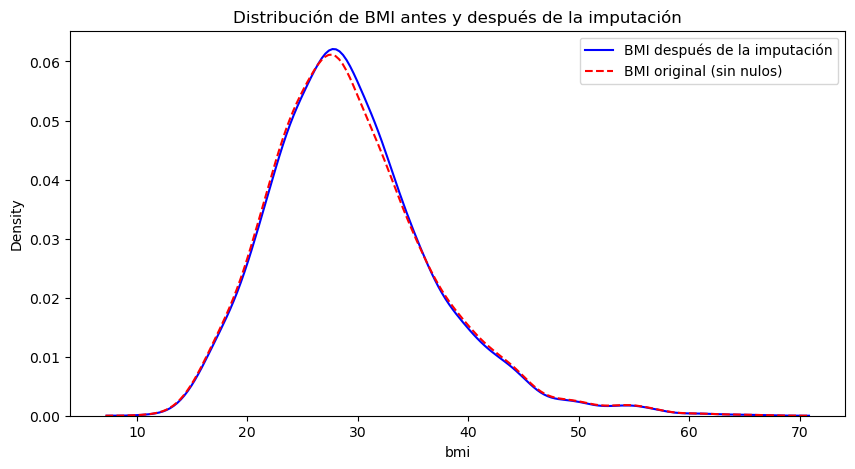

In [293]:
# Graficar la distribución de BMI
plt.figure(figsize=(10,5))
sns.kdeplot(df['bmi'], label="BMI después de la imputación", color="blue")
sns.kdeplot(bmi_original.dropna(), label="BMI original (sin nulos)", color="red", linestyle="dashed")
plt.legend()
plt.title("Distribución de BMI antes y después de la imputación")
plt.show()


***La distribución de BMI después de la imputación se mantiene similar a la original, significa que no se introdujo sesgo significativo.***

In [295]:
# Aplicar la prueba de Kolmogorov-Smirnov
ks_stat, ks_p_value = ks_2samp(bmi_original, bmi_imputed)

# Mostrar resultados
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"P-valor: {ks_p_value:.4f}")

# Interpretación
if ks_p_value > 0.05:
    print("✅ No se rechaza la hipótesis nula: Las distribuciones de BMI antes y después de la imputación no son significativamente diferentes.")
else:
    print("⚠️ Se rechaza la hipótesis nula: La distribución de BMI después de la imputación es significativamente diferente de la original.")

Estadístico KS: 0.0092
P-valor: 0.9866
✅ No se rechaza la hipótesis nula: Las distribuciones de BMI antes y después de la imputación no son significativamente diferentes.


***

## <span style="color:#1489fd;">**Estratificación de variables numéricas:**</span>

In [297]:
# Estratificar IMC
df['rango_imc'] = pd.cut(df['bmi'], 
                          bins=[0, 18.5, 24.9, 29.9, float('inf')], 
                          labels=['bajo_peso', 'saludable', 'sobrepeso', 'obeso'])

# Estratificar Edad
df['rango_etario'] = pd.cut(df['age'], 
                            bins=[4, 12, 17, 39, 59, 74, float('inf')], 
                            labels=['infante', 'adolescente', 'adulto_joven', 'adulto', 'anciano_joven', 'anciano'])


# Estratificar Glicemia Promedio
df['rango_glicemia_promedio'] = pd.cut(df['avg_glucose_level'], 
                                        bins=[0, 70, 100, 125, 200, float('inf')], 
                                        labels=['baja', 'normal', 'alta', 'muy_alta', 'extremadamente_alta'])

***

## <span style="color:#1489fd;">**Tratamiento de variable smoking_status:**</span>

**Se eliminan los fumadores desconocidos restantes:**

In [299]:
# Filtrar y eliminar las filas donde smoking_status es "desconocido"
df_sin_desconocidos = df[df['smoking_status'] != 'desconocido'].copy()

# Mostrar el número de filas eliminadas
filas_eliminadas = df.shape[0] - df_sin_desconocidos.shape[0]
print(f"Se han eliminado {filas_eliminadas} registros con smoking_status = 'desconocido'.")

# Verificar la nueva distribución de smoking_status
print("\nDistribución de smoking_status después de la eliminación:")
print(df_sin_desconocidos['smoking_status'].value_counts())

Se han eliminado 862 registros con smoking_status = 'desconocido'.

Distribución de smoking_status después de la eliminación:
smoking_status
no_fumador    2316
ex_fumador     885
fumador        788
Name: count, dtype: int64



**Estatus de fumador se transforma en una variable binaria fumador/ex_fumador = Si/No (1/0) :**

In [301]:
df = df_sin_desconocidos

In [303]:
# Asignar 1 si la categoría es 'fumador' o 'ex_fumador', y 0 en caso contrario.
df['smoker'] = np.where(df['smoking_status'].isin(['fumador', 'ex_fumador']), 1, 0)

***

## <span style="color:#1489fd;">**Definiendo Características importantes:**</span>

In [305]:
# Definir las características importantes (excluyendo variables irrelevantes)
features_importantes = ["rango_etario", "rango_glicemia_promedio", "rango_imc", "smoker", "hypertension", "heart_disease", "stroke"]

# Filtrar el dataset con solo las variables seleccionadas
df = df[features_importantes]

***

## <span style="color:#1489fd;">**Balanceo:**</span>

**Reducción de ht_0 y hd_0:**

In [307]:
n_remover = 2000  # Cambia este valor según tus necesidades

# Filtrar las filas donde heart_disease = 0 y hypertension = 0
mask = (df['heart_disease'] == 0) & (df['hypertension'] == 0)
subset = df[mask]

# Verificar que existan suficientes muestras para eliminar
if n_remover > subset.shape[0]:
    print(f"El número a eliminar ({n_remover}) es mayor que el número de muestras disponibles ({subset.shape[0]}).")
else:
    # Seleccionar aleatoriamente los índices a eliminar
    indices_a_remover = subset.sample(n=n_remover, random_state=42).index
    
    # Crear un nuevo DataFrame eliminando esos índices
    df_hthd_disminuido = df.drop(indices_a_remover)
    
    print("Se han eliminado", n_remover, "muestras.")
    print("Nuevo tamaño del DataFrame:", df_hthd_disminuido.shape)

Se han eliminado 2000 muestras.
Nuevo tamaño del DataFrame: (1989, 7)


In [309]:
df_reducido = df_hthd_disminuido

In [311]:
df_hd_0 = df_reducido[df_reducido["heart_disease"] == 0]

df_hd_0_eliminable = df_hd_0.sample(n=1500, random_state=42)

df_hd_balanceado = df_reducido.drop(df_hd_0_eliminable.index)

In [313]:
df_reducido = df_hd_balanceado

In [315]:
df_ht_0 = df_reducido[df_reducido["hypertension"] == 0]

df_ht_0_eliminable = df_ht_0.sample(n=200, random_state=42)

df_ht_balanceado = df_reducido.drop(df_ht_0_eliminable.index)


In [317]:
df_reducido = df_ht_balanceado

**Reducción de rango_glicemia_promedio normal:**

In [320]:
df_reducido_glunormal = df_reducido[df_reducido["rango_glicemia_promedio"] == "normal"]

df_glunormal_eliminable = df_reducido_glunormal.sample(n=50, random_state=42)

df_reducido_glunormal_disminuido = df_reducido.drop(df_glunormal_eliminable.index)

df_tratado = df_reducido_glunormal_disminuido

### **Síntesis de datos con CTGAN:**


In [323]:
# Preguntar cuántas muestras sintéticas de stroke=1 generar
num_synthetic_samples = int(input("Ingrese el número de muestras sintéticas de stroke=1 a generar: ")) #3583 para balancear

# Filtrar solo stroke=1 del dataset reducido para entrenar CTGAN
df_synthetic_base = df_reducido[df_reducido["stroke"] == 1].copy()

# Definir el modelo CTGAN
ctgan = CTGAN(epochs=750)  # se probó con distintos números de épocas. 750 fue la que arrojó mejores resultados hasta ahora

# Entrenar CTGAN con los datos de stroke=1
print("\n⏳ Entrenando modelo CTGAN con los datos de stroke=1...")
ctgan.fit(df_synthetic_base, discrete_columns=df_synthetic_base.columns.tolist())

# Generar datos sintéticos
print("\n🔄 Generando datos sintéticos...")
df_synthetic = ctgan.sample(num_synthetic_samples)

# Verificar las primeras filas de los datos generados
print("\n✅ Datos sintéticos generados:")
print(df_synthetic.head())

# Combinar los datos originales con los sintéticos
df_balanceado = pd.concat([df, df_synthetic], ignore_index=True)

print(f"\n📊 Se han generado {num_synthetic_samples} nuevas muestras de stroke=1 y se han agregado al dataset.\n")

Ingrese el número de muestras sintéticas de stroke=1 a generar:  3583



⏳ Entrenando modelo CTGAN con los datos de stroke=1...

🔄 Generando datos sintéticos...

✅ Datos sintéticos generados:
    rango_etario rango_glicemia_promedio  rango_imc  smoker  hypertension  \
0        anciano                  normal  saludable       0             1   
1        anciano     extremadamente_alta      obeso       1             0   
2  anciano_joven                    baja      obeso       0             1   
3        anciano                  normal  saludable       0             1   
4  anciano_joven     extremadamente_alta      obeso       1             1   

   heart_disease  stroke  
0              0       1  
1              1       1  
2              0       1  
3              0       1  
4              1       1  

📊 Se han generado 3583 nuevas muestras de stroke=1 y se han agregado al dataset.



In [146]:
### En caso de que se desee guardar el dataset balanceado en un documento CSV, descomentar ###

# df_balanceado.to_csv("stroke_5.csv", index=False)

# print("✅ Archivo 'stroke_5.csv' guardado exitosamente.")